In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym~=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
import gym

In [3]:

gym.envs.registry.all()

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

In [4]:
env = gym.make('CartPole-v1')

In [5]:
env.seed(42)
obs = env.reset()

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545], dtype=float32)

In [7]:
env.render()


True

In [10]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

c:\Users\OwenThurman\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


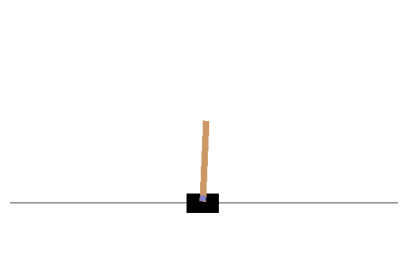

In [11]:
plot_environment(env)
plt.show()

In [8]:
env.action_space


Discrete(2)

In [16]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.04560214,  1.1670915 , -0.04242766, -1.7127857 ], dtype=float32)

In [18]:
reward

1.0

In [19]:
done

False

In [20]:
info

{}

In [21]:
if done:
    obs = env.reset()

In [22]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [23]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)


(41.718, 8.858356280936096, 24.0, 68.0)

In [24]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [25]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [26]:
plot_animation(frames)

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [28]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [29]:

frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 25ms/step


In [31]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.092

In [32]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 25ms/step


policy gradients

In [33]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [34]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [35]:

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [36]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [37]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [38]:

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95